In [11]:
import sys
import math
import random
import os
import time as chrono
import csv
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import re

import matplotlib.pyplot as plt
import scienceplots  # type: ignore

from scipy.stats import mannwhitneyu
from BSE import market_session
from functions import schedule_offsetfn_with_flash_crash, schedule_offsetfn_from_eventlist, schedule_offsetfn_read_file

plt.style.use(['science', 'no-latex'])
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "legend.fontsize": 22,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "axes.linewidth": 1,
    "axes.edgecolor": "black",
    "legend.fancybox": True,
    "legend.frameon": True,
    "legend.edgecolor": "black",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.color": "#b7b7b7",
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
})

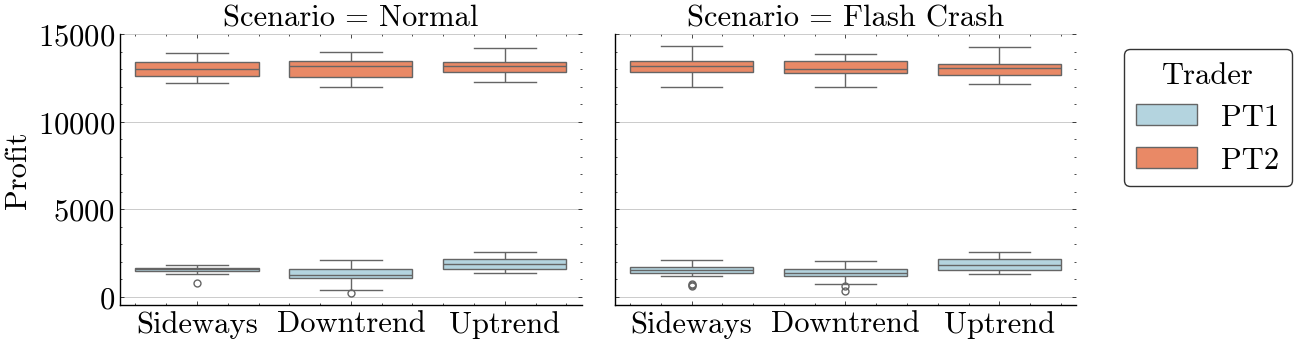

In [12]:

# idealised data
sideways_df  = pd.read_csv("idealised_plain_Sideways/simulation_results.csv")
downtrend_df = pd.read_csv("idealised_plain_Downtrend/simulation_results.csv")
uptrend_df   = pd.read_csv("idealised_plain_Uptrend/simulation_results.csv")

sideways_flash_df  = pd.read_csv("idealised_flash_Sideways/simulation_results.csv")
downtrend_flash_df = pd.read_csv("idealised_flash_Downtrend/simulation_results.csv")
uptrend_flash_df   = pd.read_csv("idealised_flash_Uptrend/simulation_results.csv")
"""  

#Realisict data

# data
sideways_df  = pd.read_csv("realistic_plain_Sideways/simulation_results.csv")
downtrend_df = pd.read_csv("realistic_plain_Downtrend/simulation_results.csv")
uptrend_df   = pd.read_csv("realistic_plain_Uptrend/simulation_results.csv")

sideways_flash_df  = pd.read_csv("realistic_flash_Sideways/simulation_results.csv")
downtrend_flash_df = pd.read_csv("realistic_flash_Downtrend/simulation_results.csv")
uptrend_flash_df   = pd.read_csv("realistic_flash_Uptrend/simulation_results.csv")
"""
# label
sideways_df["Trend"] = "Sideways"
downtrend_df["Trend"] = "Downtrend"
uptrend_df["Trend"] = "Uptrend"

sideways_flash_df["Trend"]= "Sideways"
downtrend_flash_df["Trend"] = "Downtrend"
uptrend_flash_df["Trend"] = "Uptrend"

# melt function
def melt_df(df):
    melted = df.melt(
        id_vars=["Trend"],
        value_vars=[df.columns[2], df.columns[3]],
        var_name="Trader",
        value_name="Value"
    )
    return melted

def melt_df_flash(df):
    melted = df.melt(
        id_vars=["Trend"],
        value_vars=[df.columns[4], df.columns[5]],
        var_name="Trader",
        value_name="Value"
    )
    return melted

# melt all dataframes
sideways_melt = melt_df(sideways_df)
downtrend_melt = melt_df(downtrend_df)
uptrend_melt = melt_df(uptrend_df)

sideways_flash_melt = melt_df_flash(sideways_flash_df)
downtrend_flash_melt = melt_df_flash(downtrend_flash_df)
uptrend_flash_melt= melt_df_flash(uptrend_flash_df)

# label scenario
for df_ in [sideways_melt, downtrend_melt, uptrend_melt]:
    df_["Scenario"] = "Normal"
for df_ in [sideways_flash_melt, downtrend_flash_melt, uptrend_flash_melt]:
    df_["Scenario"] = "Flash Crash"

# ccombine
combined_realistic = pd.concat([sideways_melt, downtrend_melt, uptrend_melt], ignore_index=True)
combined_flash     = pd.concat([sideways_flash_melt, downtrend_flash_melt, uptrend_flash_melt], ignore_index=True)
df_all = pd.concat([combined_realistic, combined_flash], ignore_index=True)

# remove any trailing "_profit"
df_all["Trader"] = df_all["Trader"].str.replace("_profit", "", regex=False)

### PLOOT
g = sns.catplot(
    data=df_all,
    x="Trend",
    y="Value",
    hue="Trader",
    col="Scenario",
    kind="box",
    dodge=False, # set to false for normal scneario
    palette={"PT1": "lightblue", "PT2": "coral"},
    height=4, aspect=1.5
)
g.set_axis_labels("", "Profit")
g._legend.remove()

plt.legend(bbox_to_anchor=(1.5, 1), title="Trader")
plt.tight_layout()
#plt.savefig("realistic_boxplot_res.pdf", bbox_inches="tight") # rename to id if needed
plt.savefig("realistic_boxplot_ide.pdf", bbox_inches="tight") # rename to id if needed
plt.show()


In [13]:
# data choose
uptrend_df   = pd.read_csv("realistic_flash_Uptrend/simulation_results.csv")
downtrend_df = pd.read_csv("realistic_flash_Downtrend/simulation_results.csv")
sideways_df  = pd.read_csv("realistic_flash_Sideways/simulation_results.csv")

# dictionary to hold Sharpe ratios
sharpe_ratios = {
    "Trend": [],
    "Trader": [],
    "Sharpe Ratio": []
}

# dict to map
datasets = {
    "Uptrend": uptrend_df,
    "Downtrend": downtrend_df,
    "Sideways": sideways_df
}

for trend, df in datasets.items():
    for i, trader in enumerate(["PT1", "PT2"]):

        # returns = df.iloc[:, 4 + i] # if market = idealised
        returns = df.iloc[:, 4 + i] # if market = realistic


        sr = (returns.mean() - 15) / returns.std() if returns.std() != 0 else np.nan
        sharpe_ratios["Trend"].append(trend)
        sharpe_ratios["Trader"].append(trader)
        sharpe_ratios["Sharpe Ratio"].append(sr)

# PRRRRINT
sharpe_df = pd.DataFrame(sharpe_ratios)
print(sharpe_df)



       Trend Trader  Sharpe Ratio
0    Uptrend    PT1      4.425699
1    Uptrend    PT2      2.409616
2  Downtrend    PT1      4.055155
3  Downtrend    PT2      2.024531
4   Sideways    PT1      3.669735
5   Sideways    PT2      2.374342


In [14]:
# data
uptrend_df   = pd.read_csv("realistic_flash_Uptrend/simulation_results.csv")
downtrend_df = pd.read_csv("realistic_flash_Downtrend/simulation_results.csv")
sideways_df  = pd.read_csv("realistic_flash_Sideways/simulation_results.csv")

# dictionary to hold Mann-Whitney U test results
mann_whitney_results = {
    "Trend": [],
    "U Statistic": [],
    "p-value": []
}

# dict to map
datasets = {
    "Uptrend": uptrend_df,
    "Downtrend": downtrend_df,
    "Sideways": sideways_df
}

#
for trend, df in datasets.items():
    

    # idealised
    #pt1_returns = df.iloc[:, 2]
    #pt2_returns = df.iloc[:, 3]
    
    # realistic
    pt1_returns = df.iloc[:, 4]
    pt2_returns = df.iloc[:, 5]

    u_stat, p_val = mannwhitneyu(pt1_returns, pt2_returns, alternative='two-sided')
    
    mann_whitney_results["Trend"].append(trend)
    mann_whitney_results["U Statistic"].append(u_stat)
    mann_whitney_results["p-value"].append(p_val)

# PRRRRINT
mann_whitney_df = pd.DataFrame(mann_whitney_results)
print(mann_whitney_df)


       Trend  U Statistic   p-value
0    Uptrend        331.0  0.079782
1  Downtrend        347.0  0.129670
2   Sideways        310.0  0.039167
